# Segmentations : plusieurs approches 

### I. Segmentation par clustering : kMeans 

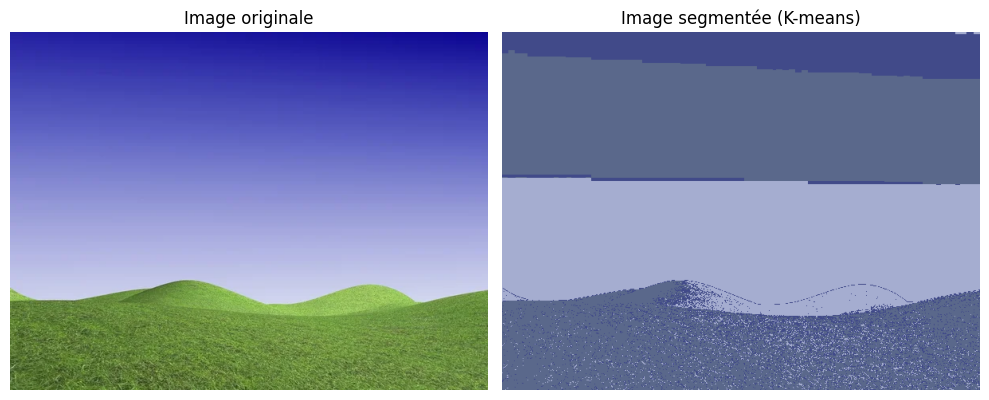

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from KMeans import KMeans 

img = imread("this.jpg")
h, w, c = img.shape
X = img.reshape(-1, 3)

model = KMeans(K=3) #objet du modèle
model.fit(X) #apprentissage
labels = model.labels_ #la il s'agit de segmenter alors, on utilise les labels appris

seg_img = model.centroids[labels].reshape(h, w, 3) #On donne a chaque pixel la valeur du centroide de son cluster

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title("Image originale")
axs[0].axis('off')

axs[1].imshow(seg_img)
axs[1].set_title("Image segmentée (K-means)")
axs[1].axis('off')

plt.tight_layout()
plt.show()
#quelques secondes (12s)

c:\Users\Asus\Desktop\Stage-M1\KMeans.py:89: RuntimeWarning: Mean of empty slice.
  self.centroids[k] = X[self.labels_ == k].mean(axis=0)
c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Asus\Desktop\Stage-M1\KMeans.py:89: RuntimeWarning: invalid value encountered in cast
  self.centroids[k] = X[self.labels_ == k].mean(axis=0)


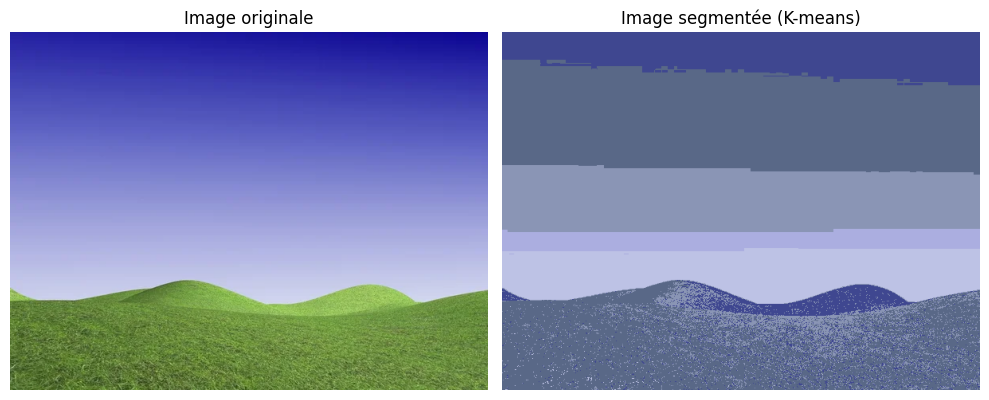

In [2]:
# K = 5
model = KMeans(K=5) 
model.fit(X) 
labels = model.labels_ 

seg_img = model.centroids[labels].reshape(h, w, 3) 

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title("Image originale")
axs[0].axis('off')

axs[1].imshow(seg_img)
axs[1].set_title("Image segmentée (K-means)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

On peut voir une segmentation, c'st assez bon, mais ca ne capture pas vraiment les régions, et dans les deux cas précédents, on veut plutot que le vert soit uni et que le ciel le soit aussi.

##### il serait tréés intéressant d'ajouter les coordonées spaciales aux features.

In [5]:

from skimage.transform import resize
img_small = resize(img, (64, 64), anti_aliasing=True)
X_small = img_small.reshape(-1, 3)

from clustering_agglomeratif import AgglomerativeClustering
model = AgglomerativeClustering(3, 'average').fit(X_small)
labels = model.labels_


clusters = [X_small[labels == i].mean(axis=0) for i in range(model.K)]  #comment j'ai pu oublier le axis=0 :')

seg_img = clusters[labels].reshape(h, w, model.K)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_small)
axs[0].set_title("Image originale")
axs[0].axis('off')

axs[1].imshow(seg_img)
axs[1].set_title("Image segmentée (agglomératif)")
axs[1].axis('off')

plt.tight_layout()
plt.show()

# ca prends 10000 ans lols


KeyboardInterrupt: 

### Watershed method

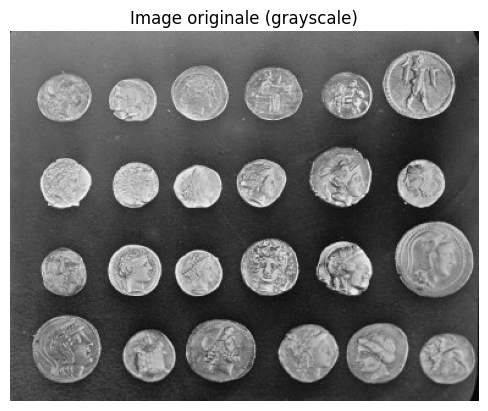

In [ ]:
# on met ici une tentative d'implémentation de la méthode WATERSHED :

from skimage import data, color
image = data.coins() #image en niveaux de gris

plt.imshow(image, cmap='gray')
plt.title("Image originale")
plt.axis('off')
plt.show()

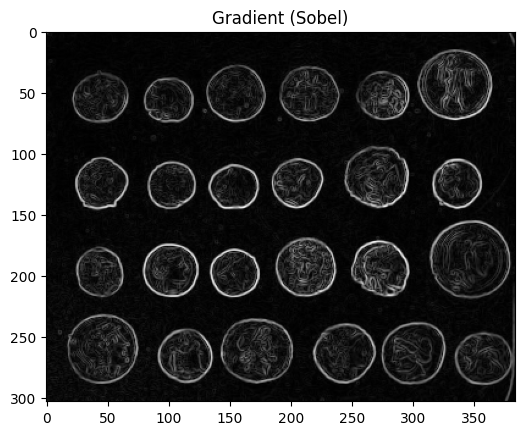

In [ ]:
# Edge detection with Sobel

from skimage.filters import sobel

grad = sobel(image) #ici a noter qu'il est possible de faire sa propre implémentation de convolve 2D en usant d'une fenetre sobel
plt.imshow(grad, cmap='gray')
plt.title("Gradient (Sobel)")
plt.axis('on') # le axis "on" pour pouvoir détecter les coordonées 
plt.show()

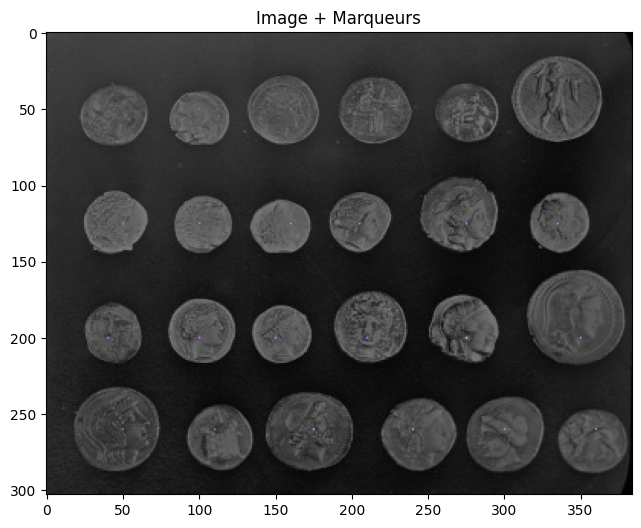

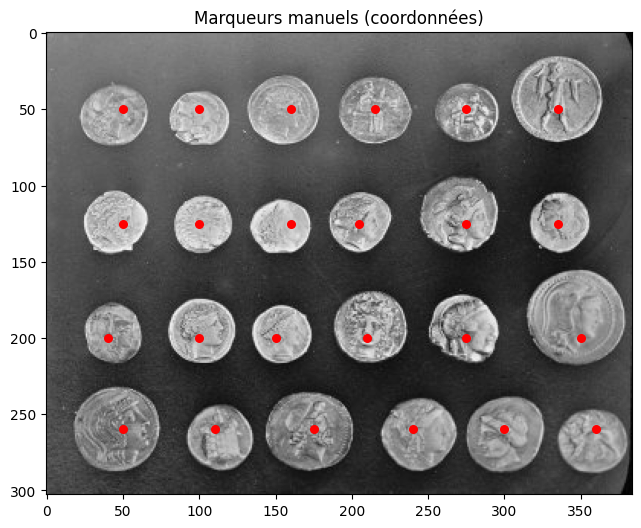

In [14]:
# marqueurs : manuellement
markers = np.zeros_like(image, dtype=np.int32)

markers[50, 50] = 1
markers[50, 100] = 2
markers[50, 160] = 3
markers[50, 215] = 4
markers[50, 275] = 5
markers[50, 335] = 6
markers[125, 50] = 7
markers[125, 100] = 8
markers[125, 160] = 9
markers[125, 205] = 10
markers[125, 275] = 11
markers[125, 335] = 12
markers[200, 40] = 13
markers[200, 100] = 14
markers[200, 150] = 15
markers[200, 210] = 16
markers[200, 275] = 17
markers[200, 350] = 18
markers[260, 50] = 19
markers[260, 110] = 20
markers[260, 175] = 21
markers[260, 240] = 22
markers[260, 300] = 23
markers[260, 360] = 24


plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.imshow(markers*40, cmap='nipy_spectral', alpha=0.5)  # superposition transparente
plt.title("Image + Marqueurs")
plt.axis('on')
plt.show()

y_coords, x_coords = np.nonzero(markers)

plt.figure(figsize=(8, 6))
plt.imshow(image, cmap='gray')
plt.scatter(x_coords, y_coords, c='red', s=30)
plt.title("Marqueurs manuels (coordonnées)")
plt.axis('on')
plt.show()

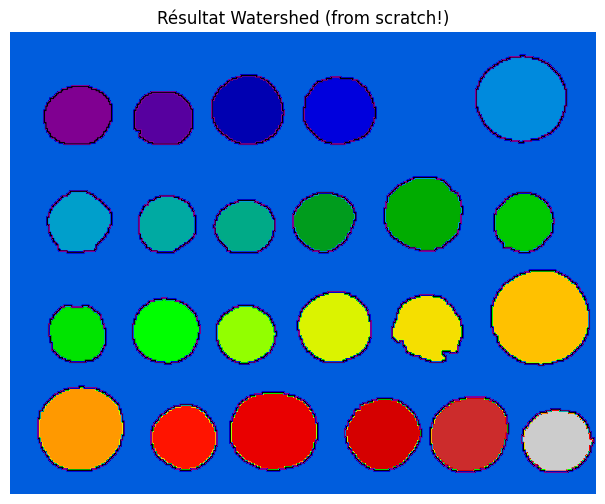

In [ ]:
#Algo watershed : cet algo n'est pas le mien, j'ai trouvé l'implémentation en ligne
import heapq

labels = markers.copy()
visited = np.zeros_like(image, dtype=bool)

heap = []  # file de priorité (min-heap)

# Initialiser la file avec tous les pixels marqués
for y in range(image.shape[0]):
    for x in range(image.shape[1]):
        if markers[y, x] > 0:
            visited[y, x] = True
            # Ajouter les voisins non visités dans la file
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]:
                        if not visited[ny, nx] and markers[ny, nx] == 0:
                            heapq.heappush(heap, (grad[ny, nx], ny, nx))

while heap:
    _, y, x = heapq.heappop(heap)

    if visited[y, x]:
        continue

    # Récupérer les labels des voisins déjà visités
    neighbor_labels = set()
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]:
                if visited[ny, nx] and labels[ny, nx] > 0:
                    neighbor_labels.add(labels[ny, nx])

    if len(neighbor_labels) == 1:
        labels[y, x] = neighbor_labels.pop()  # même région
    elif len(neighbor_labels) > 1:
        labels[y, x] = -1  # frontière

    visited[y, x] = True

    # Ajouter les voisins à la file
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            ny, nx = y + dy, x + dx
            if 0 <= ny < image.shape[0] and 0 <= nx < image.shape[1]:
                if not visited[ny, nx]:
                    heapq.heappush(heap, (grad[ny, nx], ny, nx))


plt.figure(figsize=(8, 6))
plt.imshow(labels, cmap='nipy_spectral')
plt.title("Résultat Watershed (from scratch!)")
plt.axis('off')
plt.show()

